In [18]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
#for request website 
import requests
import urllib.parse

#for Nlp
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from nltk import ngrams


nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
stop_words = list(set(stopwords.words('english')))
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
%matplotlib inline


from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
reviews_df=pd.read_csv('/content/drive/MyDrive/Data set/final Project/data_hotel_reviews_clean.csv')

In [20]:
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]


In [21]:
reviews_df["satisfied"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x > 7 else 0)
reviews_df["satisfied"].value_counts(normalize = True)


1    0.830891
0    0.169109
Name: satisfied, dtype: float64

In [22]:
reviews_df = reviews_df[["review", "satisfied"]]

In [23]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

In [24]:
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [25]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    text =[wordnet_lemmatizer.lemmatize(x) for x in text]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))


In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)


In [28]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [29]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [30]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
label = "satisfied"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In [32]:
reviews_df.head()

,review,satisfied,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yogurt,word_york,word_young,word_younger,word_yr,word_yummy,word_zero,word_ziggo,word_zone,word_zoo
499334,small rooms and the beds are freakishly high ...,1,small room bed freakishly high staff nice help...,0.062,0.589,0.349,0.8051,124,24,0.120933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
453216,Noise from the corridor Very good localizatio...,1,noise corridor good localization front undergr...,0.000,0.790,0.210,0.4927,84,15,-0.026120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483572,Some hot vegetarian food at breakfast would h...,1,hot vegetarian food breakfast would made break...,0.000,0.818,0.182,0.4404,91,15,0.158060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414918,Can t fault anything about this hotel Great l...,1,fault anything hotel great location fantastic ...,0.070,0.679,0.251,0.7845,181,33,-0.095859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248152,We were unable to get our taxi to the door of...,0,unable get taxi door hotel saturday october no...,0.118,0.882,0.000,-0.8826,536,100,-0.031680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.054309
2,pos,0.043370
0,neg,0.028739
10,doc2vec_vector_4,0.025053
1,neu,0.022543
7,doc2vec_vector_1,0.017143
6,doc2vec_vector_0,0.016861
4,nb_chars,0.016834
9,doc2vec_vector_3,0.016661
5,nb_words,0.015382


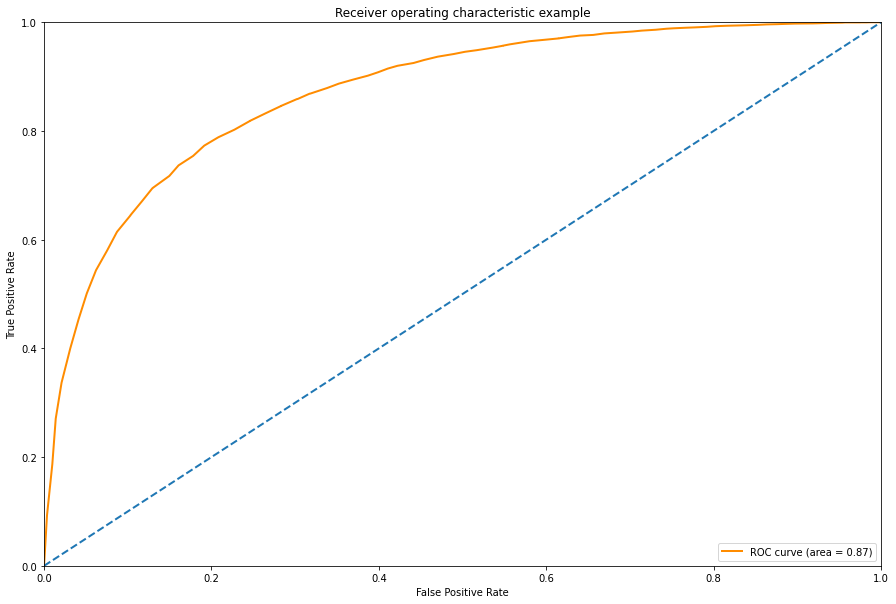

In [34]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()